# Recorte da Imagem para depois Equalizar novamente
* Iremos recortar a imagem para depois equalizar novamente pois melhora a qualidade da equalização;
* Eliminados os espaços em preto desnecessários da imagem, ficando apenas com o recorte da mama;
* Assim, melhora significativamente a qualidade da equalização, e como consequencia, melhora a qualidade do constraste da imagem permitindo visualizar muito mais as estruturas da mama.

In [1]:
import pydicom as dicom
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure
import os
from PIL import Image

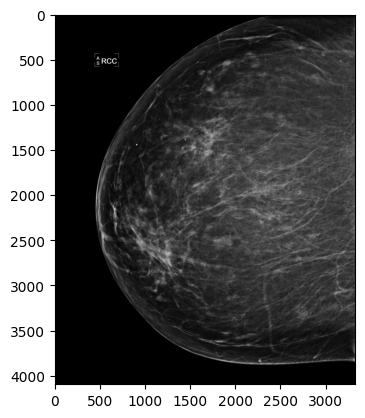

In [27]:
# Fazendo o teste para uma imagem do dataset
#localImg = "/mnt/d/ImagensDatasetFredrik/"
img = dicom.dcmread("00142_20990909_R_CC_3.dcm")

imgArray = np.array(img.pixel_array)
plt.imshow(imgArray, cmap=plt.cm.gray)

Colocar funcao do calculo dos thresholds aqui...

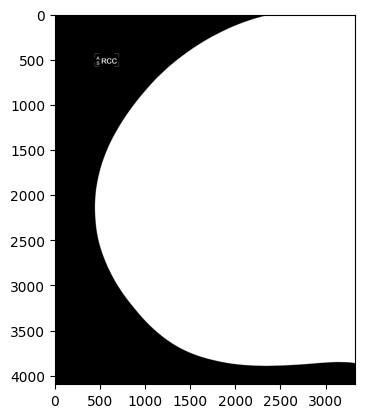

In [28]:
# todos os valores maiores que 1000 irao receber 1, senao recebe 0
ret, temp1 = cv2.threshold(imgArray, 0, np.max(imgArray), cv2.THRESH_BINARY)
arrayThresh = temp1.astype('uint8')

# verificando....
plt.imshow(arrayThresh, cmap=plt.cm.gray);

In [29]:
# Iremos pegar os contornos da imagem
# Utilizando cv2.CHAIN_APPROX_SIMPLE pegamos apenas as bordas do contorno da imagem, assim poupando processamento e memoria
countours = cv2.findContours(arrayThresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
countours = imutils.grab_contours(countours)
countours = sorted(countours, key= cv2.contourArea, reverse = True) #pegando as coordenadas que resultam na maior área
rect = cv2.boundingRect(countours[0])

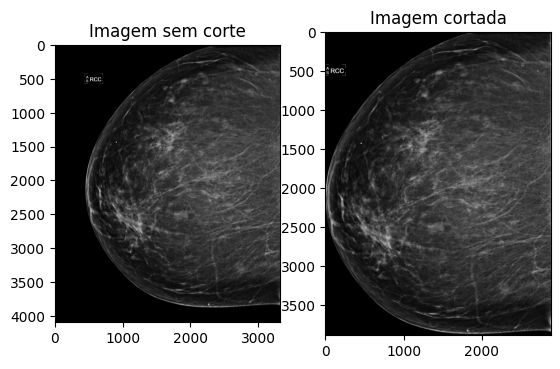

In [30]:
# Coordenadas
x,y,w,h = rect

# Corta imagem com as coordenadas
imgCroped = (imgArray)[y:y+h, x:x+w].copy()

# Comparacao
plt.subplot(1,2,1)
plt.imshow(imgArray, cmap=plt.cm.gray)
plt.title("Imagem sem corte")
plt.subplot(1, 2, 2)
plt.imshow(imgCroped, cmap=plt.cm.gray)
plt.title("Imagem cortada");

# Criando uma máscara e extraindo apenas a mama

In [4]:
# Funcao que faz o recorte da imagem e equaliza
def cut_Equalize(img):
    # Load the MRI image of the brain
    img = dicom.dcmread(img)
    imgArray = img.pixel_array

    # Apply Otsu's threshold to binarize the image
    thresh = cv2.threshold(imgArray, 0, np.max(imgArray), cv2.THRESH_BINARY)[1].astype('uint8')

    # Encontra todos os contornos da imagem
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Pega o maior contorno
    largest_contour = max(contours, key=cv2.contourArea)

    # Cria a mascara a partir do maior contorno
    mask = np.zeros_like(thresh)

    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), -1)

    # Multiply the original image with the mask to crop the irregular shape
    dst = cv2.bitwise_and(imgArray, imgArray, mask=mask)

    rect = cv2.boundingRect(largest_contour)
    # Coordenadas
    x,y,w,h = rect

    # Corta imagem com as coordenadas
    imgCroped = (dst)[y:y+h, x:x+w].copy()

    # Equalizar imagem
    imgCutEqualize = exposure.equalize_adapthist(imgCroped, clip_limit=0.1)

    return imgCutEqualize

#plt.figure(figsize=(10,10))
#plt.subplot(3,2,1)
#plt.title('imagem original')
#plt.imshow(imgArray, cmap='gray')
#plt.subplot(3,2,2)
#plt.title("Máscara da imagem")
#plt.imshow(mask, cmap='gray')
#plt.subplot(3,2,3)
#plt.title("Imagem com artefato removido")
#plt.imshow(dst, cmap='gray')
#plt.subplot(3,2,4)
#plt.title("imagem com o artefato removido e cropada")
#plt.imshow(imgCroped, cmap='gray')
#plt.subplot(3,2,5)
#plt.title("imagem com o artefato removido e cropada")
#plt.imshow(exposure.equalize_hist(imgCroped, clip_limit=0.1), cmap='gray')

### Percorremos a lista de imagens e recortamos e equalizamos cada uma, depois salvamos em uma pasta


In [ ]:
listImages = os.listdir("/mnt/d/ImagensDatasetFredrik/positive2/")

localImages = '/mnt/d/ImagensDatasetFredrik/positive2/'
localSave = '/mnt/d/ImagensDatasetFredrik/positive2/cortadoEqualizado/'

# percorre todas as imagens
for img in listImages:
    nameImg = str(img)[:-4] + '.png'
    # ja existe na cortadoEqualizado?
    if not os.path.exists(localSave+nameImg): 
        if os.path.exists(localImages+img):
            # Retira os 4 ultimos caracteres do nome da imagem
            nameImg = str(img)[:-4] + '.png'
            print('Imagem para salvar: ' + nameImg)
            imgFinal = cut_Equalize(localImages+img)
            # Salva imagem
            plt.imsave(fname=localSave+nameImg, arr=imgFinal, cmap='gray')
        else:
            print('Nao existe na ' + localImages)
    else:
        print('Imagem na pasta: ' + nameImg)
     
# Verifica se tem a mesma quantidade
if len(os.listdir(localImages)) == len(os.listdir(localSave)):
    print('Todas imagens cortadas e finalizadas!')
else:
    print('Faltou imagens!')